In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from scipy.fftpack import rfft, fftfreq, fft
import scipy.sparse as sparse
import scipy.linalg as linalg
from scipy.sparse.linalg import LinearOperator
import numpy as np
import collections
import copy
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator
import amfe
from amfe.frequency_module import frequency
from scipy import optimize
#unpack case dict

msh_file = r'meshes\2D_beam_20_elem.msh'
m = amfe.Mesh()
m.import_msh(msh_file)

ax= amfe.plot_mesh(m)
ax.axis('equal')
ax.legend(loc=2)

Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.



<IPython.core.display.Javascript object>

In [2]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)

rho = 7.86E-9 # kg/mm3
E = 210.0E3 # MPa = N/mm2
my_material = amfe.KirchhoffMaterial(E=E, nu=0.3, rho=rho, thickness=1, plane_stress=True)
my_comp.set_domain(6,my_material)


print('Number of nodes is equal to %i' %my_comp.mesh_class.no_of_nodes)

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 20 elements and 66 dofs.
Time taken for preallocation: 0.00 seconds.
Number of nodes is equal to 33


In [3]:
map_dict = {'d': {'tag_value': 1, 'direction' : 'xy'},
            'n': {'tag_value': 12, 'direction' : 'y'},
            'c': {'tag_value': 11, 'direction' : 'y'}}
                  


dirsub = m.get_submesh('phys_group', 1)
neusub = m.get_submesh('phys_group', 12)
contactsub = m.get_submesh('phys_group', 11)
domain = m.get_submesh('phys_group', 6)
id_matrix = my_comp.assembly_class.id_matrix

# get dofs
all_dofs = OrderedSet(my_comp.get_dofs(domain,direction ='xy'))
dir_dofs = OrderedSet(my_comp.get_dofs(dirsub, direction ='xy'))
neu_dofs = OrderedSet(my_comp.get_dofs(neusub, direction ='y'))
contact_dofs = OrderedSet(my_comp.get_dofs(contactsub, direction ='y'))


boundary_dofs = dir_dofs | neu_dofs | contact_dofs
interior_dofs = list(OrderedSet(all_dofs) - boundary_dofs)
dir_dofs = list(dir_dofs)
neu_dofs = list(neu_dofs)
contact_dofs = list(contact_dofs)

dof_dict = collections.OrderedDict()
dof_dict['d'] = dir_dofs 
dof_dict['n'] = neu_dofs
dof_dict['c'] = contact_dofs
dof_dict['i'] = interior_dofs

s = SelectionOperator(dof_dict,id_matrix)


WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils


In [4]:
K, f = my_comp.assembly_class.assemble_k_and_f()
M = my_comp.assembly_class.assemble_m()

Real amplitute after projection is = -112.027006 
Imag amplitute after projection is = 0.000000 


<IPython.core.display.Javascript object>


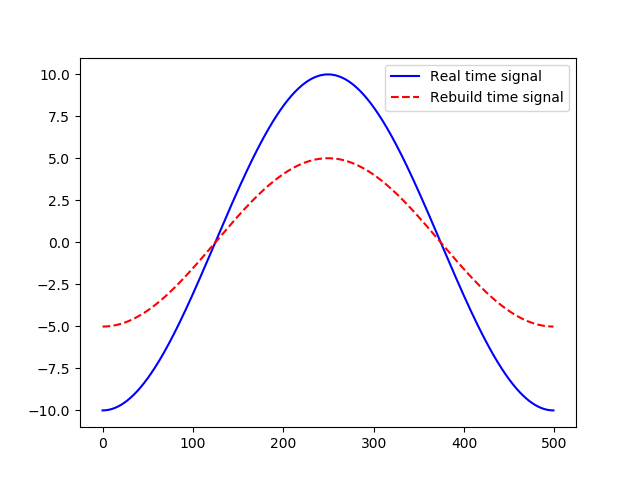

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [6]:

f0 = 10
value = -10
n_points = 500
nH = 3
force_in_time = frequency.linear_harmonic_force(a=value, f0 = f0, n_points=n_points, cos=True)
q_harm = frequency.hbm_complex_bases(f0,number_of_harm=1,n_points=n_points,static=False)

f_one_dof_ = q_harm.T.dot(force_in_time) 
print('Real amplitute after projection is = %f ' %f_one_dof_.real)
print('Imag amplitute after projection is = %f ' %f_one_dof_.imag)

f_rebuild = q_harm.dot(f_one_dof_) 

plt.figure()
plt.plot(force_in_time,'b',label='Real time signal')
plt.plot(f_rebuild,'r--',label='Rebuild time signal')
plt.legend()

In [7]:
K_red = s.assemble_matrix(K,['n','c','i'])
M_red = s.assemble_matrix(M,['n','c','i'])
C_red = 0.01*K_red + 0.0*M_red
f = f_one_dof_.real*s.build_B('n').toarray().flatten()
f_red = s.assemble_vector(f,['n','c','i'])

# Harmonic Analysis
Bc = s.build_B('c')
Z_red = frequency.create_Z_matrix(K_red,C_red,M_red,f0=f0,static=False)

u_dym_red = sparse.linalg.spsolve(Z_red,f_red)
u_dir = np.array(len(s.selection_dict['d'])*[0],dtype=np.complex)
amplitute_dim = K_red.shape[0] 
I = sparse.eye(amplitute_dim)
get_amplitute_by_t_id = lambda t_id : sparse.kron(q_harm[t_id,:],I).dot(u_dym_red)


my_comp.u_output = []
for t_id in range(n_points):
    u_dym_red_in_time = get_amplitute_by_t_id(t_id)
    u = np.append(u_dir,u_dym_red_in_time).real
    u_dym = s.P.T.dot(u) # back to original order
    my_comp.u_output.append(u_dym)

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


<IPython.core.display.Javascript object>


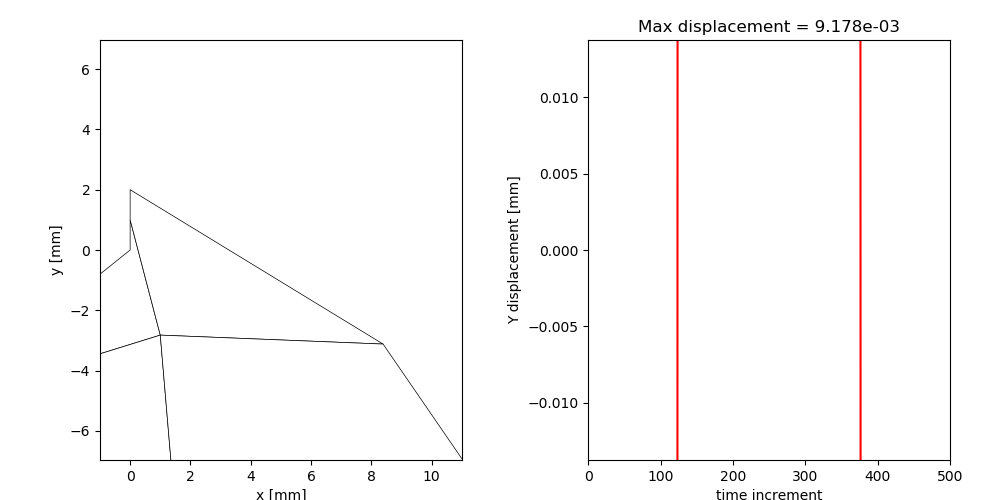

In [8]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from ipywidgets import interact
fig2, (ax21,ax22) = plt.subplots(1,2,figsize=(10,5))
#fig2, ax21 = plt.subplots(1,1,figsize=(10,5))
ax21.set_ylim([-4,6])
ax21.set_xlim([0,10])
ax21.axis('equal')
time_inc_list = list(range(0,n_points))

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

contact_dof = s.selection_dict['c'][0]
contact_dof_in_time = np.array(my_comp.u_output).T[contact_dof]
max_contact_disp = abs(contact_dof_in_time).max()

def update(u_id=0,factor=100):
    global ax21
    global ax22
    
    ax21.clear()
    ax22.clear()
    

    u_contact_disp = contact_dof_in_time[u_id]
    x = contact_dof_in_time[:u_id+1]
    t = time_inc_list[:u_id+1]
    
    ax22.plot(t,x,'r-')
    ax22.plot(u_id,u_contact_disp,'yo')
    l, ax21 = amfe.plot_2D_system_solution(my_comp,u_id=u_id,factor=factor,ax=ax21,highlight_nodes=[1])
    #ax2.axis('equal')
    ax21.set_xlabel('x [mm]')
    ax21.set_ylabel('y [mm]')
    ax22.set_title('Max displacement = %1.3e' %max_contact_disp)
    ax22.set_ylabel('Y displacement [mm]')
    ax22.set_xlabel('time increment')
    ax22.set_ylabel('Y displacement [mm]')
    p = 1.5
    ax22.set_ylim([-p*max_contact_disp,p*max_contact_disp])
    ax22.set_xlim([0,n_points])
    ax21.set_ylim([-2,2])
    ax21.set_xlim([-1,11])
    
    
    return l
    
ani = FuncAnimation(fig2, update, frames=np.arange(0, n_points ,1), blit=True, interval=1)    
#update(u_id=0)


In [9]:
def cubic_string(beta):
    
    return lambda u : beta*(u**3)

def build_nonlinear_force_in_freq(fnl,Q,Bc):
    
    return lambda u_ : Bc.T.dot(Bc.dot(Q.T.dot((fnl(Q.dot(u_))))))
    
def build_nonlinear_force_in_freq_with_Q_red(fnl,Q_red):
    
    return lambda u_ : Q_red.T.dot((fnl(Q_red.dot(u_))))
    
def build_residual(Z,fnl_,fl_):
    ''' 
    Parameters
        Z : np.array
            Dynamic stiffness matrix
        fnl : lambda function
            
        
    '''
    
    return lambda u_ : Z.dot(u_) + fnl_(u_) - fl_

# Harmonic Analysis
K_red = s.assemble_matrix(K,['n','c','i'])
M_red = s.assemble_matrix(M,['n','c','i'])
C_red = 0.001*K_red + 0.0*M_red
f = f_one_dof_.real*s.build_B('n').toarray().flatten()
f_red = s.assemble_vector(f,['n','c','i'])

Bc_red = s.reduced_selector.build_B('c')
Bn_red = s.reduced_selector.build_B('n')

f0 = 30.0
number_of_harm=10
value = -100000
n_points = 500
beta = 1000.0
complex_data= False
static=False

force_in_time = frequency.linear_harmonic_force(a=value, f0 = f0, n_points=n_points, cos=True)
q = frequency.hbm_complex_bases(f0,number_of_harm=number_of_harm,n_points=n_points, static=static, complex_data= complex_data)
Z_red = frequency.create_Z_matrix(K_red,C_red,M_red,f0=f0,nH=number_of_harm, static=static, complex_data= complex_data)

fl_1dof_ = q.T.dot(force_in_time) # creating 1 dof force in Frequency domain

u_dym_red = sparse.linalg.spsolve(K_red,f_red)


# building multidimentional Harmonic Basis
amplitute_dim = K_red.shape[0] 
I = sparse.eye(amplitute_dim)

Q = sparse.kron(I,q)
I_harm = sparse.eye(number_of_harm)
Bc_aug = sparse.kron(I_harm, Bc_red)
Bn_aug = sparse.kron(I_harm, Bn_red)
Q_red = sparse.kron(Bc_red ,q)
#fl_aug_ = sparse.kron(I_harm, fl_)


fnl = cubic_string(beta)
fnl_ = build_nonlinear_force_in_freq(fnl,Q,Bc_aug)
fnl2_ = build_nonlinear_force_in_freq_with_Q_red(fnl,Q_red)
fl_ = Bn_aug.T.dot(fl_1dof_) # creating multiple dofs force in Frequency domain
R_func = build_residual(Z_red,fnl_,fl_)

#ul_ = sparse.linalg.spsolve(Z_red,fl_)
u_ = np.random.rand(Z_red.shape[0])
R_func(u_)
opt_obj = optimize.root(R_func,u_,method='krylov')
x0 = opt_obj.x

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [10]:
#I_red = sparse.hstack([I]*number_of_harm) # create matrix for sumation of amplitudes
u_dir = np.array(len(s.selection_dict['d'])*[0])
get_amplitute_by_t_id = lambda t_id : sparse.kron(q[t_id,:],I).dot(x0)

u_ndym = []
for t_id in range(n_points):
    unl_ = get_amplitute_by_t_id(t_id)
    u = np.append(u_dir,unl_)    
    u_ndym.append(s.P.T.dot(u)) # back to original order

#time_list = list(np.arange(0,1/(f0), 0.0005))
#u_time_list = list(map(lambda t : np.cos(2.0*np.pi*f0*t)*u_ndym, np.arange(0,1/(f0), 0.0005)))


In [ ]:
my_comp.u_output = []
my_comp.u_output.extend(u_ndym)

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
fig3, (ax31,ax32) = plt.subplots(1,2,figsize=(10,5))
#fig2, ax21 = plt.subplots(1,1,figsize=(10,5))
ax31.set_ylim([-4,6])
ax31.set_xlim([0,10])
ax31.axis('equal')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

contact_dof = s.selection_dict['c'][0]
contact_dof_in_time = np.array(my_comp.u_output).T[contact_dof]
t = list(range(0,len(contact_dof_in_time)))
u_max = max(contact_dof_in_time)
def update2(u_id=0,mult=0.1):
    global ax21
    global value
    ax31.clear()
    ax32.clear()
    ax31.set_xlabel('x [mm] ')
    ax32.set_ylabel('y displacement [mm]')
    
    u_contact_disp = contact_dof_in_time[u_id]
    #mult = 1000/abs(value) 
    x =  1.0*contact_dof_in_time[:u_id+1]
    time_slice = t[:u_id+1]
    ax32.plot(time_slice,x,'r-')
    #ax32.plot(contact_dof_in_time,'r-')
    ax32.plot(time_slice[-1],x[-1],'yo')
    l, ax31x = amfe.plot_2D_system_solution(my_comp,u_id=u_id,factor=mult, ax=ax31, highlight_nodes=[1],facecolor=(0.8,0.8,0.8))
    #ax2.axis('equal')
    ax32.set_xlabel('time step ')
    ax32.set_ylabel('y displacement [mm]')
    ax32.set_ylim([-u_max*1.5,u_max*1.5])
    ax32.set_xlim([0,len(contact_dof_in_time)])
    
    return l
    
ani = FuncAnimation(fig3, update2, frames=np.arange(0, len(contact_dof_in_time) ,1), blit=True, interval=1)    
#update2(0)

from matplotlib.animation import FuncAnimation, writers


Writer = animation.writers['imagemagick']
writer = Writer(fps=60, metadata=dict(artist='Guilherme Jenovencio'), bitrate=1000)
ani.save('HBM_beam.gif', dpi=200, writer=writer)


<IPython.core.display.Javascript object>

C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\ge72tih\AppData\Local\Continuum\anaconda3\envs\ndcsi\lib\site-packages\matplotlib\transforms.py:968: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 1] = interval


In [ ]:
N = n_points
T = 1/(f0)
dt = T/(N-1)
fft_obj = frequency.Fourier(T,dt)
fft_obj.freq_list

plt.figure()
plt.plot(fft_obj.freq_list,np.abs(fft_obj.fourier_transform(contact_dof_in_time)),'b--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [mm]')

In [ ]:
plt.figure()
plt.plot(fft_obj.freq_list,np.angle(fft_obj.fourier_transform(contact_dof_in_time)),'b--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Shift [mm]')